# Preprocessing for Clustering 1.

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.cluster.hierarchy as sch

from sklearn.cluster import AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

import sys
sys.path.append("../..")

from src.support_prep import *
from src.support_eda import plot_col

import warnings
warnings.filterwarnings("ignore")


In [21]:
df = pd.read_pickle("../../datos/clean.pkl")
df = df.drop(columns = ["order_date", "ship_date", "country"])

In [22]:
df.head()

,ship_mode,segment,market,region,category,sub-category,sales,quantity,discount,profit,shipping_cost,order_priority
0,Same Day,Consumer,US,East,Technology,Accessories,2309.650,7,0.0,762.1845,933.57,Critical
1,Second Class,Corporate,APAC,Oceania,Furniture,Chairs,3709.395,9,0.1,-288.7650,923.63,Critical
2,First Class,Consumer,APAC,Oceania,Technology,Phones,5175.171,9,0.1,919.9710,915.49,Medium
3,First Class,Home Office,EU,Central,Technology,Phones,2892.510,5,0.1,-96.5400,910.16,Medium
4,Same Day,Consumer,Africa,Africa,Technology,Copiers,2832.960,8,0.0,311.5200,903.04,Critical


In [23]:
cat_cols = df.select_dtypes("O").columns
num_cols = df.select_dtypes("number").columns

## Encoding

Vamos a realizar un encoding de frecuencia para nuestras diferentes variables categóricas. Esto nos convertirá cada una de las categorías de las variables en su frecuencia de aparición. Será el primer approach, pero esto hará que se le de más peso a las categorías más frecuentes.

In [24]:
df_freq = df.copy()
for col in cat_cols:
    
    frecuencia = df[col].value_counts(normalize=True)
    df_freq[col] = df[col].map(frecuencia)


In [25]:
df_freq.head()

,ship_mode,segment,market,region,category,sub-category,sales,quantity,discount,profit,shipping_cost,order_priority
0,0.052661,0.517021,0.194853,0.055527,0.197719,0.059953,2309.650,7,0.0,762.1845,933.57,0.076662
1,0.200994,0.300819,0.214506,0.067986,0.192552,0.066953,3709.395,9,0.1,-288.7650,923.63,0.076662
2,0.146325,0.517021,0.214506,0.067986,0.197719,0.065451,5175.171,9,0.1,919.9710,915.49,0.573855
3,0.146325,0.182160,0.194970,0.216748,0.197719,0.065451,2892.510,5,0.1,-96.5400,910.16,0.573855
4,0.052661,0.517021,0.089433,0.089433,0.197719,0.043342,2832.960,8,0.0,311.5200,903.04,0.076662


## Feature Scaling

En cuanto al scaling, en el EDA pudimos ver que nuestros datos presentaban muchos outliers, de los cuales nos interesa mantener la información, por lo que usaremos un robust scaler para que las *features* estén todas alrededor de la misma escala, pero conservando la información de atípicos.

In [26]:
df_freq_rob, rob_scaler = scale_data(data = df_freq, columns = df_freq.columns, method = "robust")

## PCA

Para poder intuir el número de clusters que queremos obtener, podemos reducir la dimensionalidad de nuestros datos. En primera instancia nos encontramos con un gran número de columnas, que serían nuestras dimensiones iniciales. Sin embargo, con tantas columnas es muy complicado visualizar los datos de una forma general, por lo que usando un PCA reduciremos las dimensiones a algo más manejable y visualizable, como 3 dimensiones.

In [27]:
pca = PCA(n_components=3)
df_reduced = pd.DataFrame(pca.fit_transform(X = df_freq_rob), columns=["x","y","z"])

Text(0.5, 0, 'z')

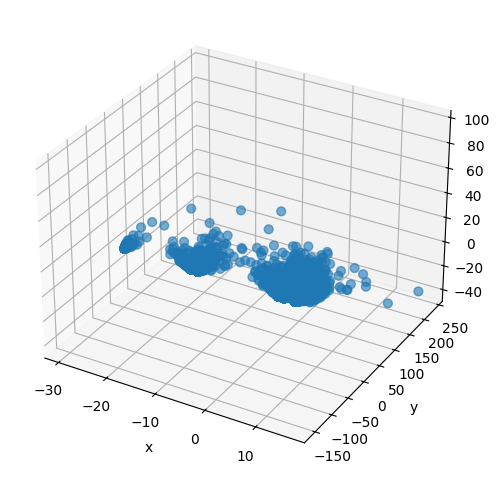

In [28]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
cmap = plt.get_cmap("Set1")

sc = ax.scatter(
    df_reduced["x"], 
    df_reduced["y"], 
    df_reduced["z"], 
    s=40, 
    marker='o',
    alpha=0.6
)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

Vemos que los datos están más o menos agrupados en 3 grupos principales, uno más pequeño que los demás. Esto indica que puede que en este caso el mejor número de clusters sea 3.

## Clustering

### DBSCAN

Comenzaremos con un DBSCAN, ya que visualizando los datos desde el PCA, vemos que nuestros puntos se encuentran en formas irregulares y que además tenemos algún que otro dato que podría considerarse ruido. El DBSCAN nos permitirá filtrar todo este ruido y clasificarlo en una categoría aparte.

En vez de iterar sobre diferentes parámetros directamente, podemos primero ver cuáles serán los más óptimos. Para **MinPts**, el consenso suele ser $min_{pts} \geq D+1$, con D las dimensiones que tengamos. También suele escogerse $min_{pts} \approx 2D$. Vamos a escoger un valor intermedio, como $D + D/2$.

En cuanto a epsilon, se escoge observando las distancias al k-ésimo vecino, **k** siendo $k = min_{pts} - 1$, ordenados de menor a mayor y escogiendo el punto "codo" de nuestra visualización.

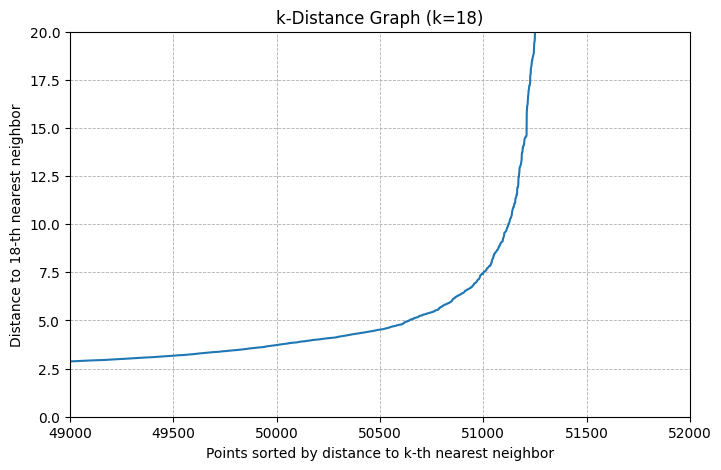

In [29]:
from sklearn.neighbors import NearestNeighbors

k = int(1.5 * len(df.columns))
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(df_freq_rob)
distances, indices = neighbors_fit.kneighbors(df_freq_rob) # Nos va a devolver las distancias y el índice del k-ésimo vecino más cercano.

# Ordenar las distancias al k-ésimo vecino
distances = np.sort(distances[:, k-1], axis=0)  # Selecciona la distancia del k-ésimo vecino


plt.figure(figsize=(8, 5))
plt.grid(ls = "--", lw = 0.6)
sns.lineplot(distances)
plt.title(f"k-Distance Graph (k={k})")
plt.xlabel("Points sorted by distance to k-th nearest neighbor")
plt.ylabel(f"Distance to {k}-th nearest neighbor")
plt.ylim(0,20)
plt.xlim(49000, 52000)
plt.show()

Visto el gráfico, eps estará sobre los 7.5. Escogeremos este valor y comprobaremos los clusters que se generan.

In [30]:
modelo = DBSCAN(min_samples=14, eps = 7.5, n_jobs=-1)

modelo.fit_predict(X = df_freq_rob)

array([-1, -1, -1, ...,  0,  0,  0], dtype=int64)

In [31]:
df_freq_rob["cluster"] = modelo.labels_

Text(0.5, 0, 'z')

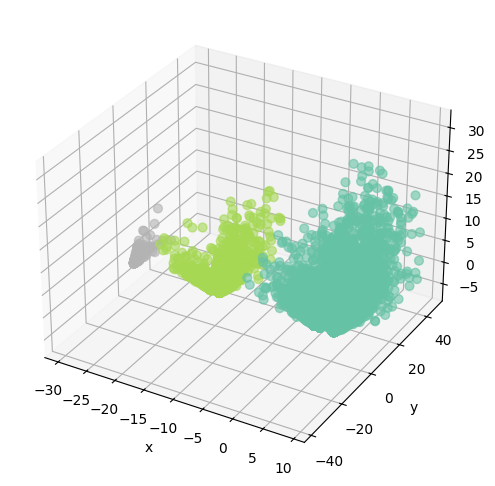

In [32]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
cmap = plt.get_cmap("Set2")
x = df_freq_rob.drop(index = df_freq_rob[df_freq_rob["cluster"] == -1].index)["cluster"]
sc = ax.scatter(
    df_reduced["x"].drop(index = df_freq_rob[df_freq_rob["cluster"] == -1].index), 
    df_reduced["y"].drop(index = df_freq_rob[df_freq_rob["cluster"] == -1].index), 
    df_reduced["z"].drop(index = df_freq_rob[df_freq_rob["cluster"] == -1].index), 
    c = x,
    cmap = cmap,
    s=40, 
    marker='o',
    alpha=0.6
)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
# fig.show()

Vemos que los clusters formados son aquellos que se especularon en la fase del PCA. En cuanto a las métricas:

In [15]:
print(f'Silhouette : {silhouette_score(df_freq_rob, df_freq_rob["cluster"]):.3f}')
print(f'Davies : {davies_bouldin_score(df_freq_rob, df_freq_rob["cluster"]):.3f}')

Silhouette : 0.707
Davies : 1.768


El hecho de tener un silhouette bueno pero un davies bouldin peor indica que nuestros clusters tienen buena separación pero no son idealmente compactos y hay solapamiento entre ellos. Ahora veamos la cardinalidad de los diferentes grupos.

In [16]:
df_freq_rob["cluster"].value_counts()

cluster
 0    41183
 1     9577
 2      380
-1      150
Name: count, dtype: int64

Vemos que nos ha detectado y separado 150 registros catalogados como ruido. Al ser una muestra tan pequeña, podemos eliminarla más adelante como outlier.

Separando tipos de datos


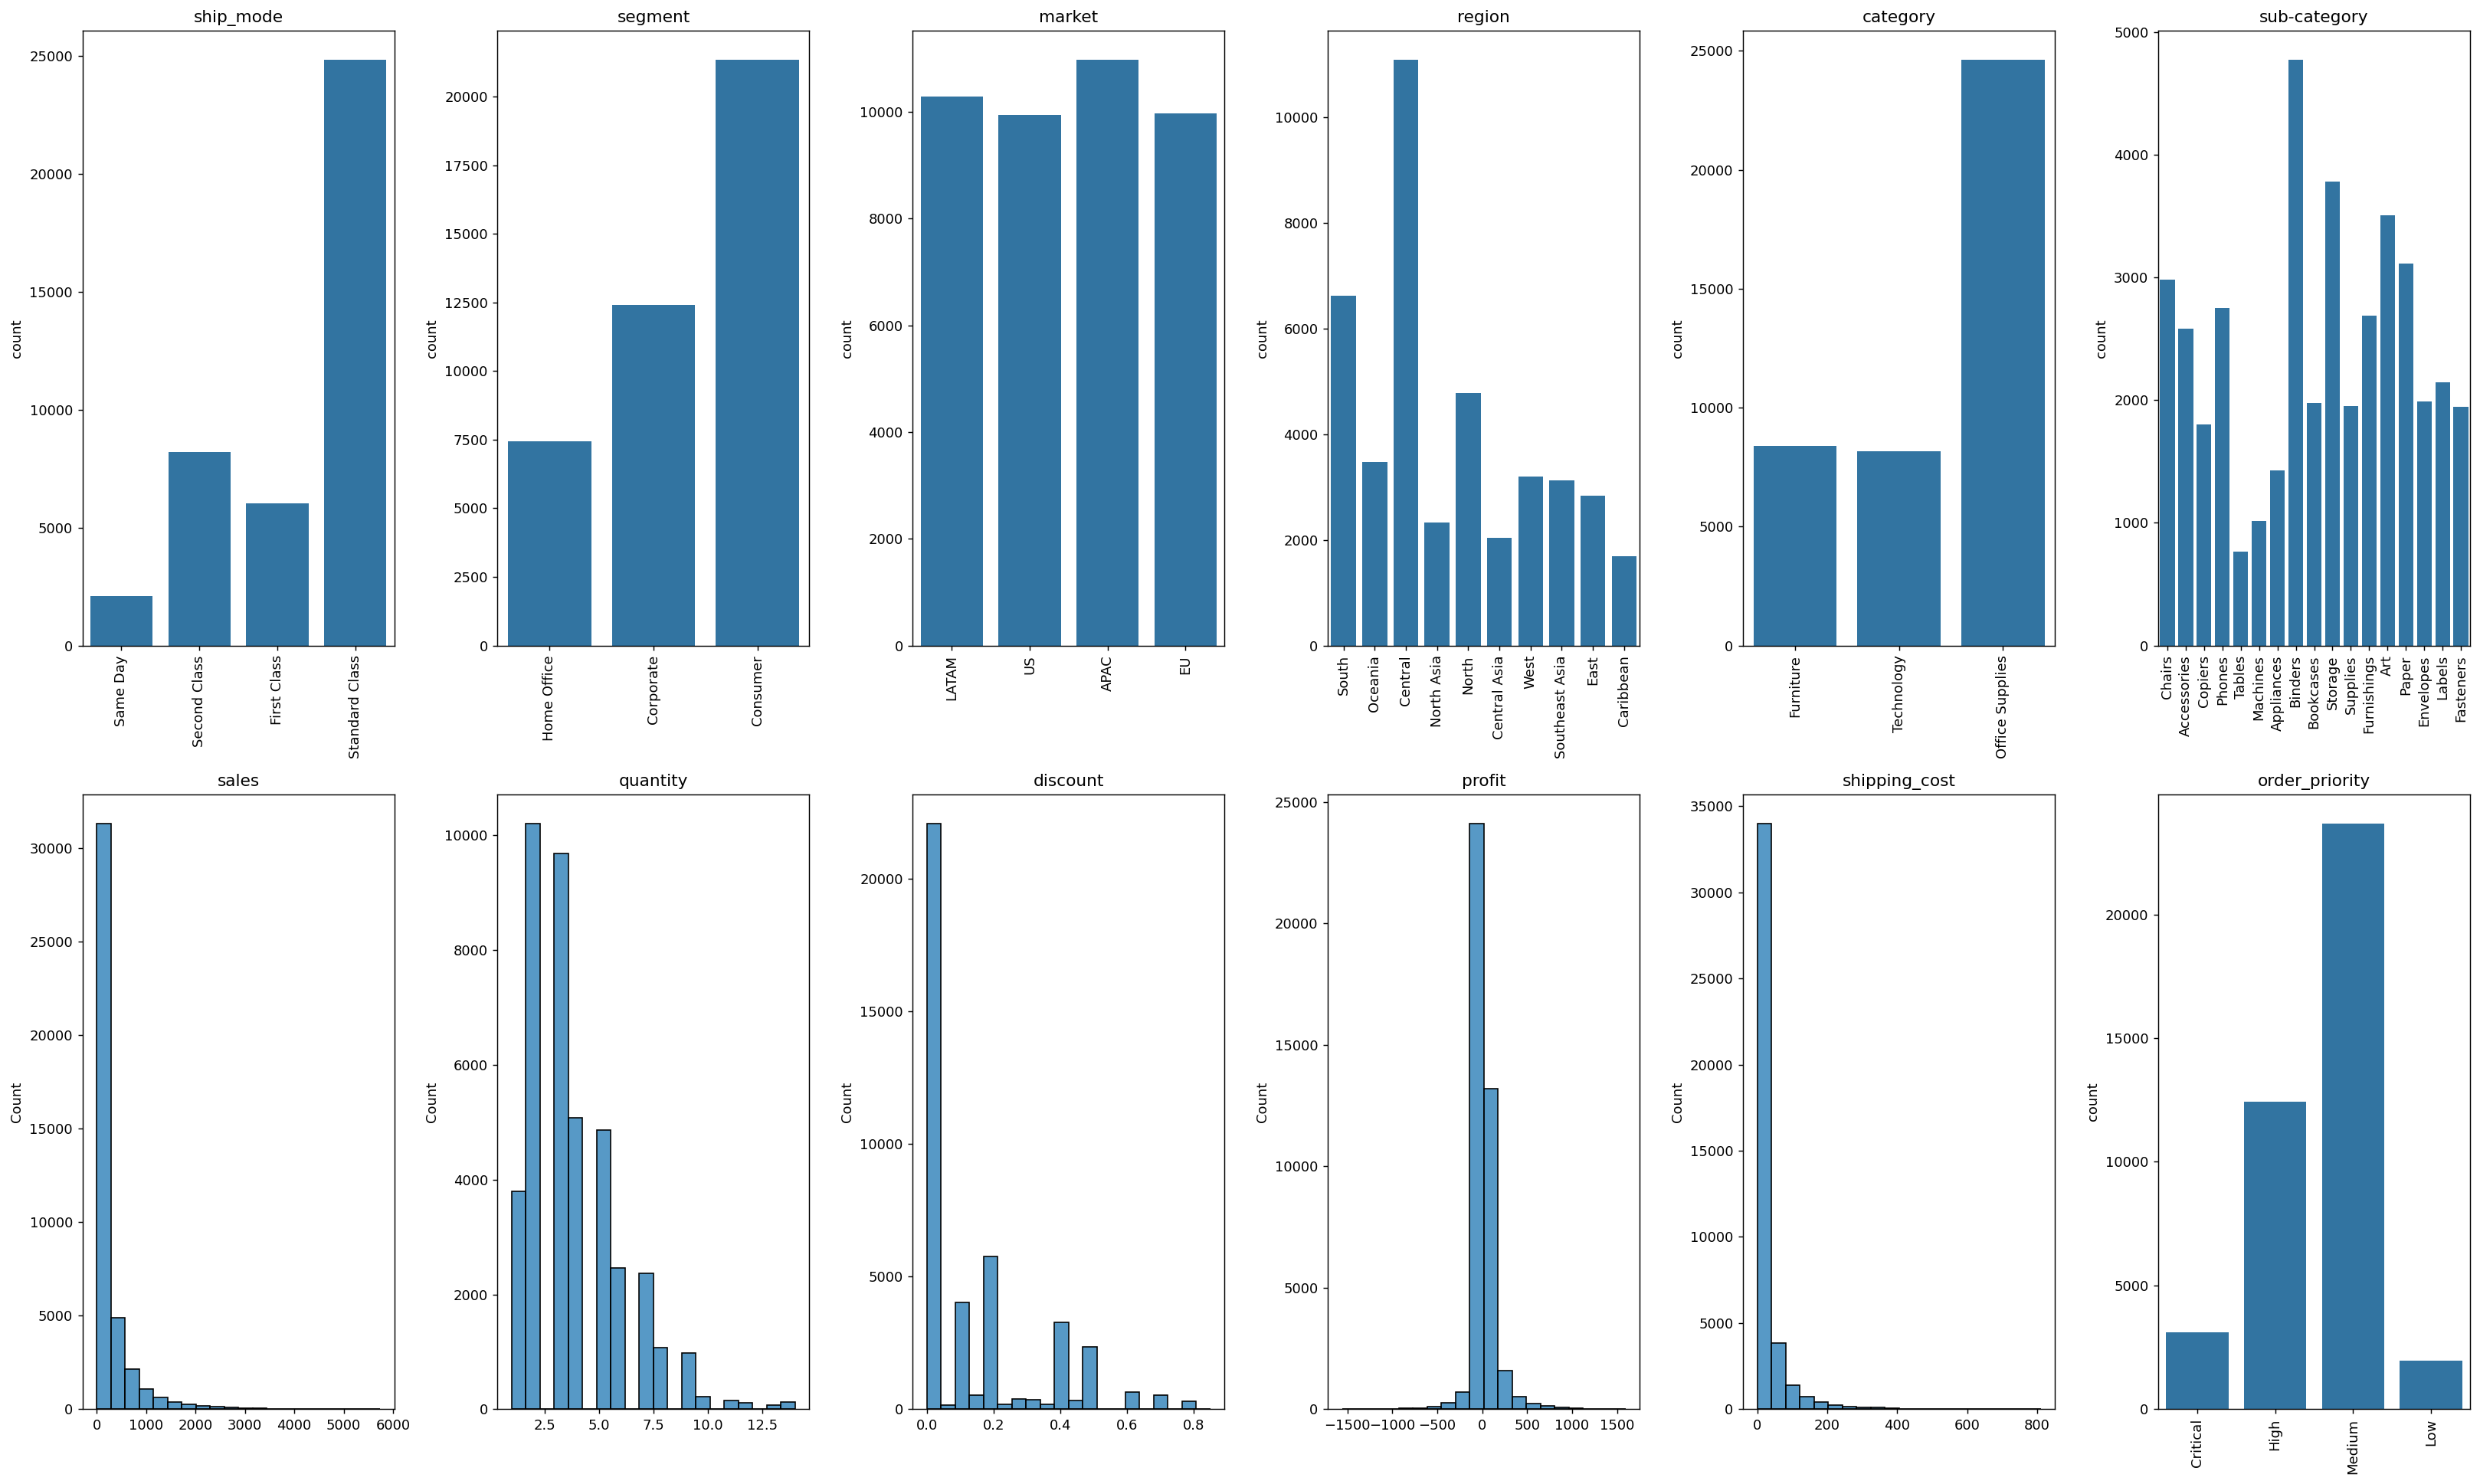

Separando tipos de datos


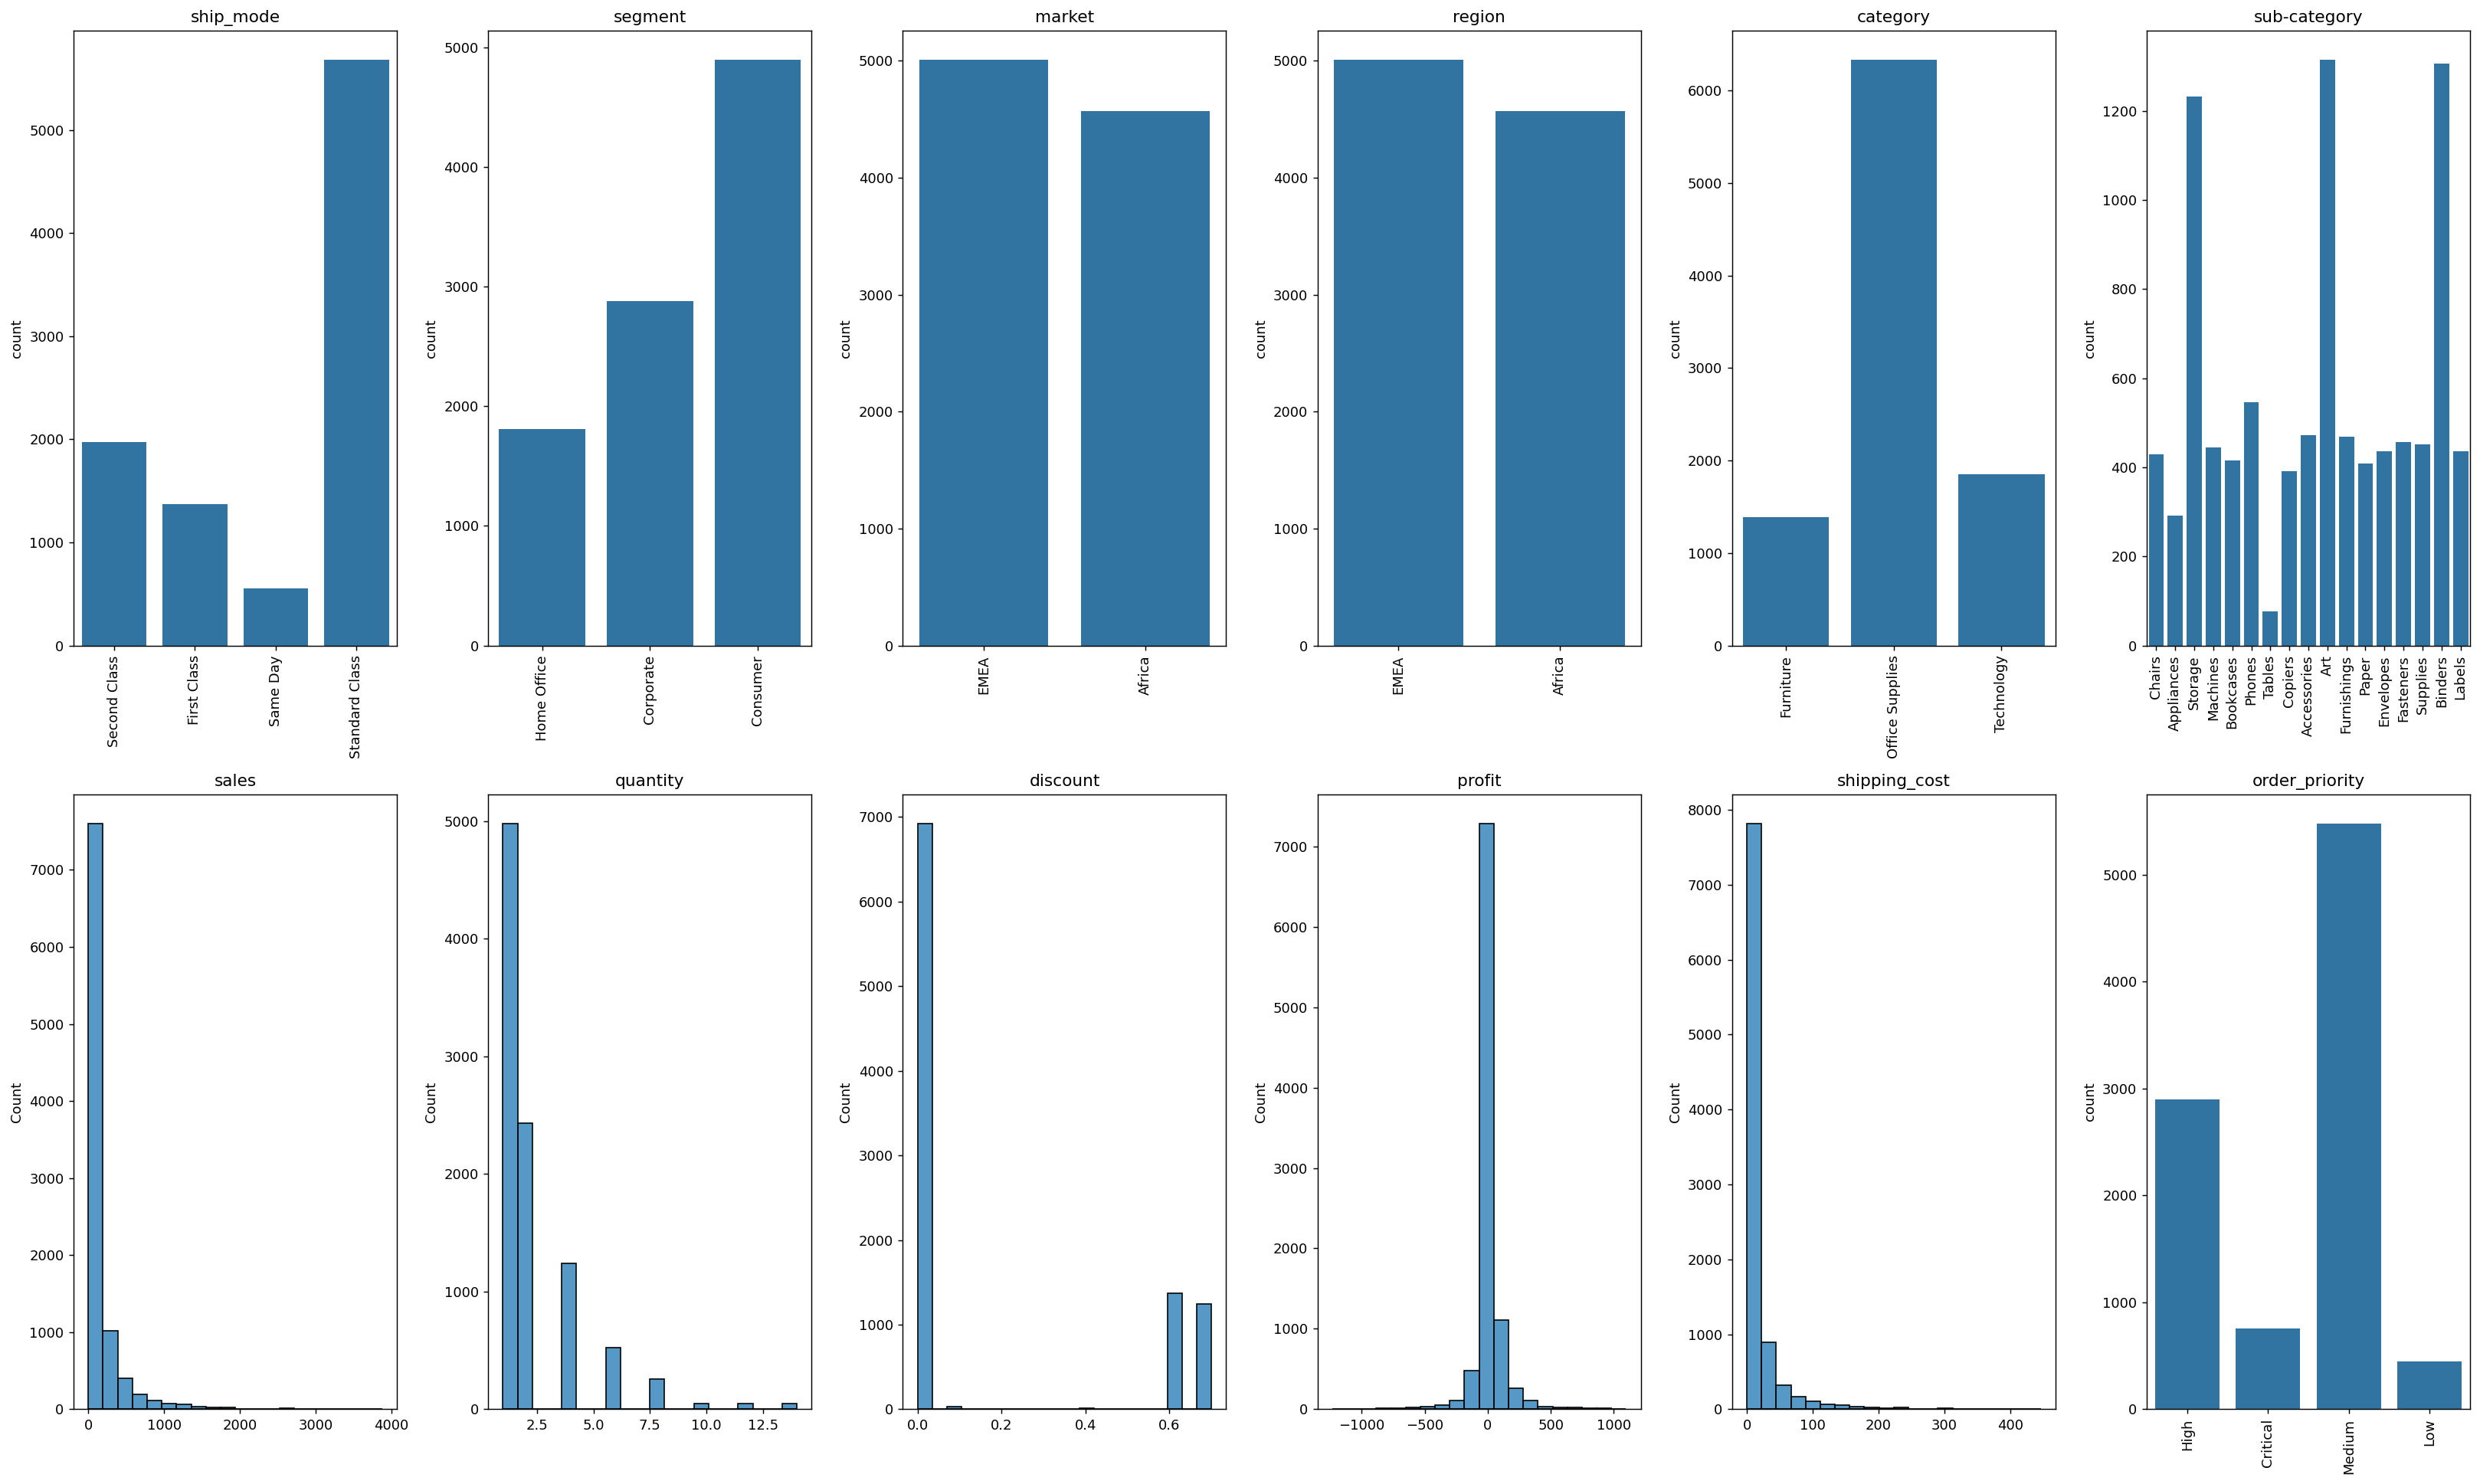

Separando tipos de datos


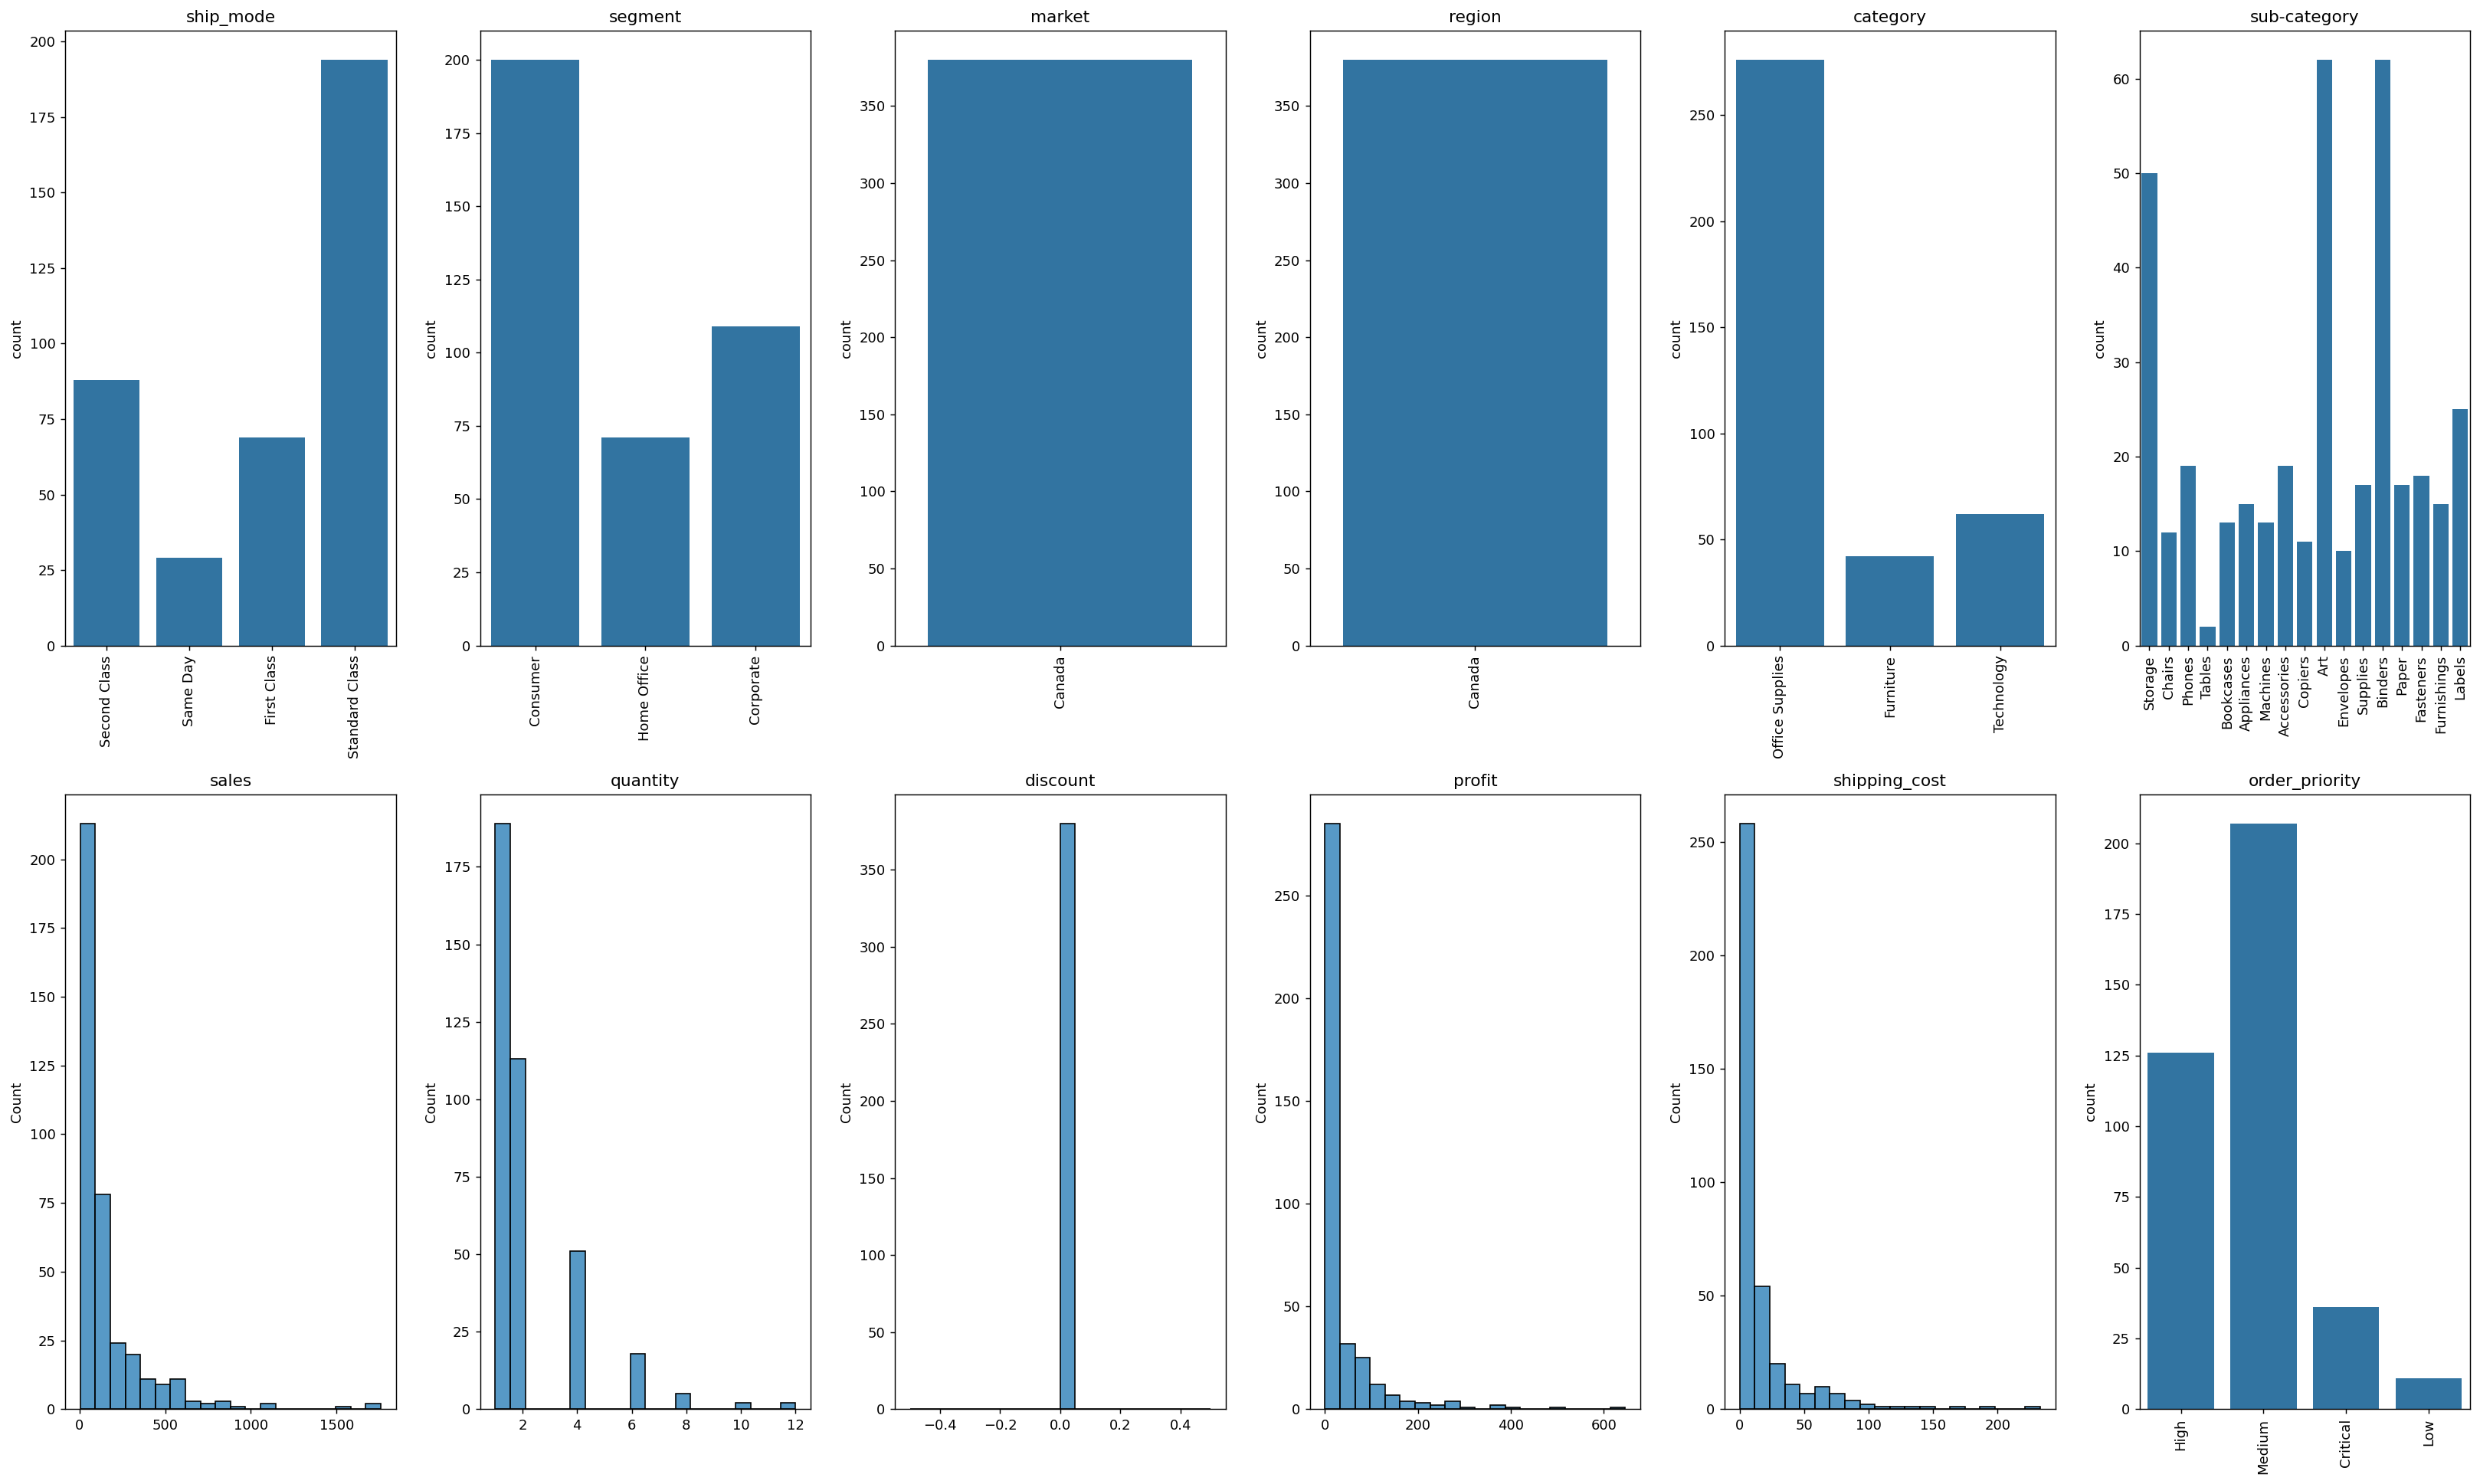

In [19]:
%matplotlib inline

plot_col(df[df_freq_rob["cluster"] == 0], x = df.columns)
plot_col(df[df_freq_rob["cluster"] == 1], x = df.columns)
plot_col(df[df_freq_rob["cluster"] == 2], x = df.columns)

Parece que la principal diferencia entre clusters es el mercado. Esto lo podemos visualizar de una mejor forma usando un plot radar.

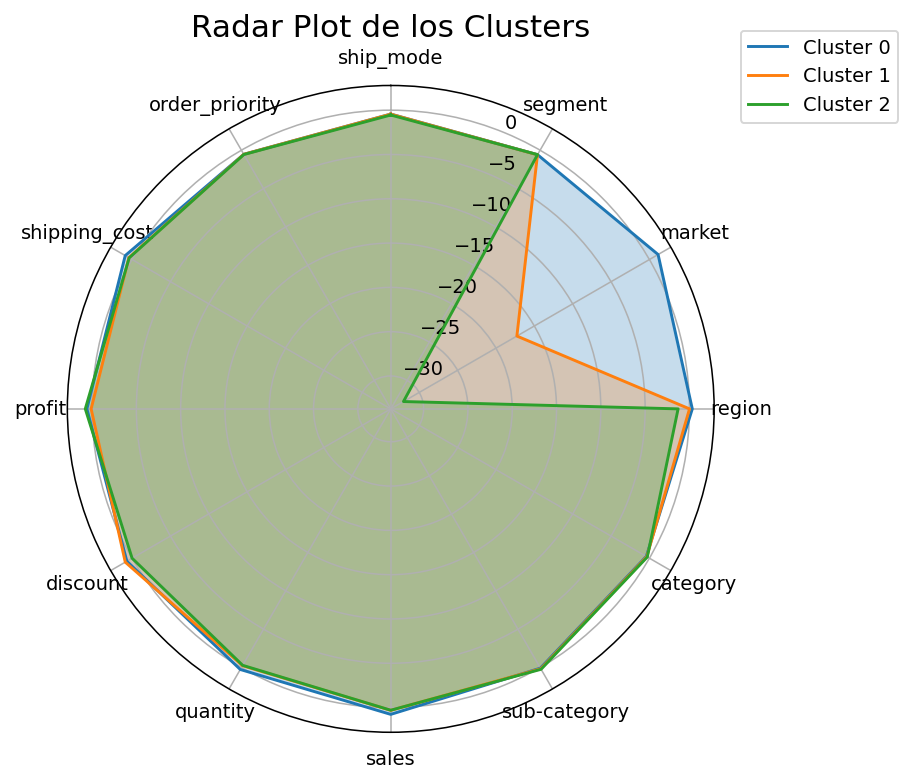

In [18]:
df_noout = df_freq_rob.drop(index = df_freq_rob[df_freq_rob["cluster"]==-1].index)
variables = df_noout.columns.drop("cluster")

cluster_means = df_noout.groupby('cluster')[variables].mean()

# Repetir la primera columna al final para cerrar el radar
cluster_means = pd.concat([cluster_means, cluster_means.iloc[:, 0:1]], axis=1)

# Crear los ángulos para el radar plot
num_vars = len(variables)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Cerrar el gráfico

# Crear el radar plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True), dpi = 140)

# Dibujar un gráfico para cada cluster
for i, row in cluster_means.iterrows():
    ax.plot(angles, row, label=f'Cluster {i}')
    ax.fill(angles, row, alpha=0.25)

# Configurar etiquetas de los ejes
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(variables)

# Añadir leyenda y título
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.title('Radar Plot de los Clusters', size=16)
plt.show()

Vemos que en esta iteración, la clusterización se ha realizado por mercado. Además, vemos con el gráfico de radio que se ha agrupado por diferentes valores, que en este caso al haber realizado un encoding de frecuencia, se ha agrupado por la frecuencia que presenta cada uno de estos mercados en nuestros datos. Sin embargo, esta clusterización puede no ser la mejor forma de agrupar a los diferentes clientes, ya que no se obtiene información de los hábitos de los clientes. Para mejorar esto, se ejecutará un encoding diferente en la siguiente iteración.